In [1]:
from rdkit import Chem
from typing import List, Dict, Tuple, Set
from collections import namedtuple, deque
from rdkit.Chem import ChemicalFeatures,AllChem
import numpy as np
import torch
def get_mol(smiles: str, kekulize: bool = False) -> Chem.Mol:
    """SMILES string to Mol.

    Parameters
    ----------
    smiles: str,
        SMILES string for molecule
    kekulize: bool,
        Whether to kekulize the molecule
    """
    mol = Chem.MolFromSmiles(smiles)
    #mol = Chem.AddHs(mol)
    #AllChem.EmbedMolecule(mol)
    #AllChem.UFFOptimizeMolecule(mol)
    if mol is not None and kekulize:
        Chem.Kekulize(mol)
    return mol

def get_bond_info(mol: Chem.Mol) -> Dict:
    """Get information on bonds in the molecule.

    Parameters
    ----------
    mol: Chem.Mol
        Molecule
    """
    if mol is None:
        return {}

    bond_info = {}
    for bond in mol.GetBonds():
        a_start = bond.GetBeginAtom().GetAtomMapNum()
        a_end = bond.GetEndAtom().GetAtomMapNum()

        key_pair = sorted([a_start, a_end])
        bond_info[tuple(key_pair)] = [bond.GetBondTypeAsDouble(), bond.GetIdx()]
    return bond_info

/users/PCON0041/xiaohu/.local/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_reaction_core(r: str, p: str, use_h_labels: bool = False) -> Tuple[Set, List]:
    """Get the reaction core and edits for given reaction

    Parameters
    ----------
    r: str,
        SMILES string representing the reactants
    p: str,
        SMILES string representing the product
    use_h_labels: bool,
        Whether to use change in hydrogen counts in edits
    """
    reac_mol = get_mol(r)
    prod_mol = get_mol(p)

    if reac_mol is None or prod_mol is None:
        print(reac_mol, prod_mol)
        return set(), []

    
    prod_bonds = get_bond_info(prod_mol)
    #print('prod_bonds:', prod_bonds)
    p_amap_idx = {atom.GetAtomMapNum(): atom.GetIdx() for atom in prod_mol.GetAtoms()} #assign product atom index
    #print('prod_map:', p_amap_idx)
    #print('                  ')
    
    max_amap = max([atom.GetAtomMapNum() for atom in reac_mol.GetAtoms()])
    for atom in reac_mol.GetAtoms():
        if atom.GetAtomMapNum() == 0:
            atom.SetAtomMapNum(max_amap + 1)
            max_amap += 1
    reac_bonds = get_bond_info(reac_mol)
    #print('reactants_bonds:',reac_bonds)
    reac_amap = {atom.GetAtomMapNum(): atom.GetIdx() for atom in reac_mol.GetAtoms()} #assign reactants atom index
    #print('reactants_map:', reac_amap)
    
    rxn_core = set()
    rxn_core1 = set()

    for bond in prod_bonds:
        if bond in reac_bonds and prod_bonds[bond][0] != reac_bonds[bond][0]:
            a_start, a_end = bond
            a_start, a_end = sorted([a_start, a_end])
            rxn_core.update([a_start, a_end])

        if bond not in reac_bonds:
            a_start, a_end = bond
            start, end = sorted([a_start, a_end])
            rxn_core.update([a_start, a_end])

    for bond in reac_bonds:
        if bond not in prod_bonds:
            amap1, amap2 = bond
            if (amap1 in p_amap_idx) and (amap2 in p_amap_idx):
                a_start, a_end = sorted([amap1, amap2])
                rxn_core.update([a_start, a_end])
                
                
                
    if use_h_labels:
        if len(rxn_core1) == 0:
            for atom in prod_mol.GetAtoms():
                amap_num = atom.GetAtomMapNum()

                numHs_prod = atom.GetTotalNumHs()
                numHs_reac = reac_mol.GetAtomWithIdx(reac_amap[amap_num]).GetTotalNumHs()

                if numHs_prod != numHs_reac:
                    rxn_core1.add(amap_num)
    #return rxn_core

    return rxn_core

In [3]:
def remove_duplicates(lines):
    new_lines = set()
    for line in lines:
        new_lines.add(line)
    return list(new_lines)

def canonicalize_SMILES(line):
    mol = Chem.MolFromSmiles(line)
    if mol is None: 
        return None
    nmol = Chem.Mol(mol)
    for at in nmol.GetAtoms(): 
        at.SetAtomMapNum(0)
    line = Chem.MolToSmiles(mol,True)
    new_line = Chem.MolToSmiles(nmol,True)
    return new_line

In [ ]:
import pandas as pd
from rdkit import RDLogger 
import requests
RDLogger.DisableLog('rdApp.*')

id = 0
fin = 'data_from_CJHIF_utf8'
reader = open(fin, 'r+')
writer = open(fin+'_converted_new','w')
writer.write('reactant>>product'+'\n')
for line in reader.readlines():
    id += 1
    if id == 50000:
        break;
    if id%1000 == 0: 
        print(id)
    line = line.strip()
    strs = line.split('§')
    #print(strs)
    if not len(strs) == 7: 
        continue
    reaction = strs[0]
    rate = float(strs[6])
    reagent = strs[3]
    solvent = strs[4]
    catalyst = strs[5]

    strss = reaction.split('>>')
    if not len(strss) == 2: 
        continue
    reactant = canonicalize_SMILES(strss[0])
    product = canonicalize_SMILES(strss[1])
    if reactant is None or product is None: 
        continue

        
    solvents = solvent.split('|')
    catalysts = catalyst.split('|')
    reagents = reagent.split('|')
    
    s = []
    c = []
    a = []
    for x in solvents:
        try:
            url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/' + x + '/property/CanonicalSMILES/TXT'
    #         remove new line character with rstrip
            smiles = requests.get(url).text.rstrip()
            if('NotFound' in smiles):
                continue
            else:
                s.append(smiles)
        except:
            continue
        
    for x in catalysts:
        try:
            url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/' + x + '/property/CanonicalSMILES/TXT'
    #         remove new line character with rstrip
            smiles = requests.get(url).text.rstrip()
            if('NotFound' in smiles):
                continue
            else:
                c.append(smiles)
        except:
            continue   
            
    for x in reagents:
        try:
            url = 'https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/' + x + '/property/CanonicalSMILES/TXT'
    #         remove new line character with rstrip
            smiles = requests.get(url).text.rstrip()
            if('NotFound' in smiles):
                continue
            else:
                a.append(smiles)
        except:
            continue
    #print(s,c,a)        
    if len(s)==0 and len(c)==0 and len(a)==0:
        continue  
        
    rxn = reactant + '>>' + '.'.join(a) + '.'.join(s) + '.' + '.'.join(c) + '>>' + product + '>>' + str(rate) + '\n'
    #writer.write(reactant+'>>'+product+'\t'+reagent+'\t'+solvent+'\t'+catalyst+'\t'+str(rate)+'\n')
    writer.write(rxn)
    writer.flush()

#print(id)
print('over')


In [4]:
#reaction§reaction with atom-mapping§functional group 1
#;§functional group 2;§reagent 1|reagent 2§solvent 1|solvent 2 §catalyst 1|catalyst 2§yield
import pandas as pd
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')
y = []
r = []
p = []
a = []
p_size = []
i=0
from rxnmapper import RXNMapper
mapped_rxn = []
rxnmapper = RXNMapper()

with open("data_from_CJHIF_utf8_converted_new") as file_in:
    for line in file_in:
        if i%1000==0:
            print(i)
        #if i==10000:
        #    break
        i += 1
        
        if len(line.split('>>'))!=4:
            #print('wrong line')
            continue
       
        yie = float(line.split('>>')[-1].replace("\n",""))
            #print(yie)
            
        
        ri = str(line.split('>>')[0])
            #print(ri)
            
        pi = str(line.split('>>')[2])
            #print(pi)
            
        
        ai = line.split('>>')[1].split('.')[:-1]
            #ai = line.replace('§','.')
        j_ai = '.'.join(ai)
            #print(j_ai)
            
            
        rxn = ri + '>>' + pi
        try:
            rxn_new = rxnmapper.get_attention_guided_atom_maps([rxn])[0]['mapped_rxn']
            mapped_rxn.append(rxn_new)
        except:
            print('wrong reaction')
            continue
        y.append(yie)
        r.append(ri)
        p.append(pi)
        a.append(j_ai)


dic = {'mapped_rxn':mapped_rxn, 'reactants':r, 'reagents':a, 'products':p, 'yield':y}
df = pd.DataFrame(dic)
df.to_csv('sample_test_CJ_5w.csv',index=False)

Some weights of the model checkpoint at /users/PCON0041/xiaohu/anaconda3/envs/rxnfp/lib/python3.6/site-packages/rxnmapper/models/transformers/albert_heads_8_uspto_all_1310k were not used when initializing AlbertModel: ['predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.decoder.weight', 'predictions.decoder.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


Token indices sequence length is longer than the specified maximum sequence length for this model (627 > 512). Running this sequence through the model will result in indexing errors


wrong reaction
wrong reaction
wrong reaction
wrong reaction
19000
20000
wrong reaction
21000
wrong reaction
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
wrong reaction
32000
33000
34000
35000
36000
wrong reaction
wrong reaction
wrong reaction
wrong reaction
wrong reaction
wrong reaction
wrong reaction
37000
38000
39000
40000
41000
42000
43000
44000
45000
wrong reaction
wrong reaction
46000
47000
48000
49000
50000
51000
52000


In [62]:
import pandas as pd
index = []
r_mapped = []
r_unmapped = []
a_u = []
p_mapped = []
p_u = []
y = []
core = []
core_index = []
label = []
updated_reactions = []


#df = pd.read_csv('sample_test_CJ_5w.csv')
df_ori = pd.read_csv('sample_test_CJ_5w.csv').dropna()
df_ori = df_ori[df_ori['yield']!=0]
print(df_ori.shape)
#df_ori.to_csv('sample_test_CJ_5w_wo0.csv')


df = df_ori.sample(n=1153, replace=False, random_state=42)
#42
print(df.shape)
error = []
reactants = df['reactants'].values
products = df['products'].values
yie = df['yield'].values
for i in range(df.shape[0]): 
    if yie[i] == 0:
        continue
        
    else:
        rxn = df['mapped_rxn'].values[i]
        mapped_r = rxn.split('>>')[0]      
        mapped_p = rxn.split('>>')[1]
        r = df['reactants'].values[i]
        a = df['reagents'].values[i]
        p = df['products'].values[i]
        
    if r=='' or a =='' or p=='':
        continue
        
    else: 
        try:     
            rxn_core = get_reaction_core(mapped_r,mapped_p)
            if(rxn_core == set()):
                error.append(i)
                continue

            else:
                core_index_atom = []
                for ri in mapped_r.split('.'):
                    #print(ri)
                    reac_moli = get_mol(ri)
                    moli_center = [str(atom.GetIdx()) for atom in reac_moli.GetAtoms() if (atom.GetAtomMapNum() in rxn_core)]
                    moli_center = '.'.join(moli_center)
                    core_index_atom.append(moli_center)
                core_index_atom = '>'.join(core_index_atom)
            if core_index_atom == '':
                continue
            else:
                core_index.append(core_index_atom)
                #print(r,a,p)

                reaction_original = r + '>' + a + '>' + p #FOR T5CHEM
                
                updated_reactions.append(reaction_original)
                y.append(yie[i])
                index.append(i) 

                a_u.append(a)
                r_unmapped.append(r)
                r_mapped.append(mapped_r)
                p_u.append(p)
                p_mapped.append(mapped_p)

                core.append(rxn_core)
  
        except:
            error.append(i) #can be used to index the deleted reactions!!!!
            #print(yie[i], core_index_atom)
    
print(len(y),len(a_u),len(r_mapped),len(r_unmapped), len(updated_reactions), len(p_mapped), len(p_u), len(core),len(core_index))
print(len(error))
data = {'reactants_mapped': r_mapped,'reactants':r_unmapped, 'reagents':a_u, 'products_mapped':p_mapped, 'products':p_u, 'yield':y, 'core_index_mapping': core, 'core_index_atom': core_index}
df1 = pd.DataFrame(data)
print(df1.head(3))
df1.to_csv('sample_test_CJ_processed_final_5w_wo0.csv', index=False)

with open("../Data4T5chem/uspto500mt_new/sample_test_CJ_final_5w_wo0.source", 'w') as f:
    for line in updated_reactions:
        f.write(f"{line}\n")
        
with open("../Data4T5chem/uspto500mt_new/sample_test_CJ_final_5w_wo0.target", 'w') as f:
    for line in y:
        f.write(f"{line}\n")
        


(29698, 5)
(1153, 5)
1000 1000 1000 1000 1000 1000 1000 1000 1000
152
                                    reactants_mapped  \
0  [CH3:1][CH2:2][C@H:3]([CH3:4])[CH2:5][OH:6].Cl...   
1  [CH2:1]=[CH:2][CH2:3][OH:4].Cl[Si:5]([CH3:6])(...   
2  [O:1]=[C:2]([OH:3])/[CH:4]=[CH:5]/[c:6]1[cH:7]...   

                             reactants          reagents  \
0  CC[C@H](C)CO.Cc1ccc(S(=O)(=O)Cl)cc1  CCN(CC)CCC(Cl)Cl   
1           C=CCO.CC(C)(C)[Si](C)(C)Cl           C(Cl)Cl   
2                   O=C(O)/C=C/c1ccco1            [HH]CO   

                                     products_mapped  \
0  [CH3:1][CH2:2][C@H:3]([CH3:4])[CH2:5][O:6][S:7...   
1  [CH2:1]=[CH:2][CH2:3][O:4][Si:5]([CH3:6])([CH3...   
2  [O:1]=[C:2]([OH:3])[CH2:4][CH2:5][c:6]1[cH:7][...   

                           products  yield core_index_mapping core_index_atom  
0  CC[C@H](C)COS(=O)(=O)c1ccc(C)cc1   68.0             {6, 7}             5>1  
1           C=CCO[Si](C)(C)C(C)(C)C   86.0             {4, 5}             3>1  

1000


Text(0, 0.5, 'number of reactions')

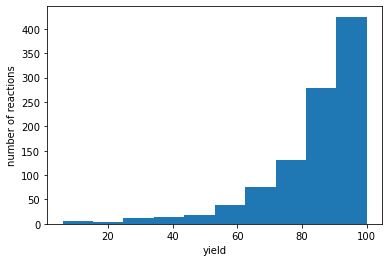

In [63]:
print(len(df1))
import matplotlib.pyplot as plt
y = np.array(y)
plt.hist(y,bins=10)
plt.xlabel('yield')
plt.ylabel('number of reactions')